In [1]:
# 모듈 불러오기
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from matplotlib import pyplot as plt

In [12]:
# 분석 환경 설정
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")

print('Current device is', device)

Current device is cpu


In [3]:
# HyperParameter 지정
batch_size = 50
epoch_num = 15
learning_rate = 0.0001

In [4]:
# MNIST 데이터 불러오기
train_data = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './data', train = False, transform = transforms.ToTensor())

print('number of training data: ', len(train_data))
print('number of test data: ', len(test_data))

number of training data:  60000
number of test data:  10000


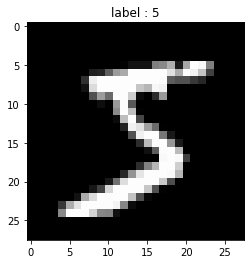

In [5]:
# MNIST 데이터 확인하기
image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap = 'gray')
plt.title('label : %s' % label)
plt.show()

In [6]:
# 미니 배치 구성하기
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)

first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


In [7]:
# CNN 구조 설계하기
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim = 1)
        return output

In [8]:
# Optimizer 및 손실 함수 정의
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss( )

In [9]:
# 설계한 CNN 모형 확인하기
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
# 모델 학습
model.train()
i = 0
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}'.format(i, loss.item()))
        i += 1

Train Step: 0	Loss: 2.318


/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Step: 1000	Loss: 0.291
Train Step: 2000	Loss: 0.214
Train Step: 3000	Loss: 0.064
Train Step: 4000	Loss: 0.030
Train Step: 5000	Loss: 0.166
Train Step: 6000	Loss: 0.115
Train Step: 7000	Loss: 0.016
Train Step: 8000	Loss: 0.142
Train Step: 9000	Loss: 0.165
Train Step: 10000	Loss: 0.021
Train Step: 11000	Loss: 0.009
Train Step: 12000	Loss: 0.016
Train Step: 13000	Loss: 0.016
Train Step: 14000	Loss: 0.049
Train Step: 15000	Loss: 0.005
Train Step: 16000	Loss: 0.067
Train Step: 17000	Loss: 0.015


In [11]:
# 모델 평가
model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('Test set: Accuracy: {:.2f}%'.format(100 * correct / len(test_loader.dataset)))

Test set: Accuracy: 99.06%
